In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('../data/train_processed.csv')
df.head()

,file_1,file_2,real_text_id
0,The VIRSA (Visible Infrared Survey Telescope A...,The China relay network has released a signifi...,1
1,China\nThe goal of this project involves achie...,The project aims to achieve an accuracy level ...,2
2,Scientists can learn about how galaxies form a...,Dinosaur eggshells offer clues about what dino...,1
3,China\nThe study suggests that multiple star s...,The importance for understanding how stars evo...,2
4,Dinosaur Rex was excited about his new toy set...,Analyzing how fast stars rotate within a galax...,2


In [3]:
df['real_text_id'] -= 1

In [4]:
df.isna().sum()

file_1          1
file_2          1
real_text_id    0
dtype: int64

In [5]:
df = df.dropna().reset_index(drop=True)

### Creating some new features

In [6]:
df['length_1'] = df['file_1'].apply(lambda x: len(x.split()))
df['length_2'] = df['file_2'].apply(lambda x: len(x.split()))
df['length_diff'] = df['length_1'] - df['length_2']
df['special_char_ratio_1'] = df['file_1'].apply(lambda x: sum(1 for c in x if not c.isalnum()) / len(x) if len(x) > 0 else 0)
df['special_char_ratio_2'] = df['file_2'].apply(lambda x: sum(1 for c in x if not c.isalnum()) / len(x) if len(x) > 0 else 0)
df['special_char_ratio_diff'] = df['special_char_ratio_1'] - df['special_char_ratio_2']

In [7]:
df.head()

,file_1,file_2,real_text_id,length_1,length_2,length_diff,special_char_ratio_1,special_char_ratio_2,special_char_ratio_diff
0,The VIRSA (Visible Infrared Survey Telescope A...,The China relay network has released a signifi...,0,304,296,8,0.152550,0.163033,-0.010483
1,China\nThe goal of this project involves achie...,The project aims to achieve an accuracy level ...,1,454,137,317,0.160051,0.170940,-0.010889
2,Scientists can learn about how galaxies form a...,Dinosaur eggshells offer clues about what dino...,0,159,125,34,0.154522,0.166042,-0.011521
3,China\nThe study suggests that multiple star s...,The importance for understanding how stars evo...,1,263,262,1,0.177001,0.148743,0.028258
4,Dinosaur Rex was excited about his new toy set...,Analyzing how fast stars rotate within a galax...,1,34,123,-89,0.200000,0.161883,0.038117


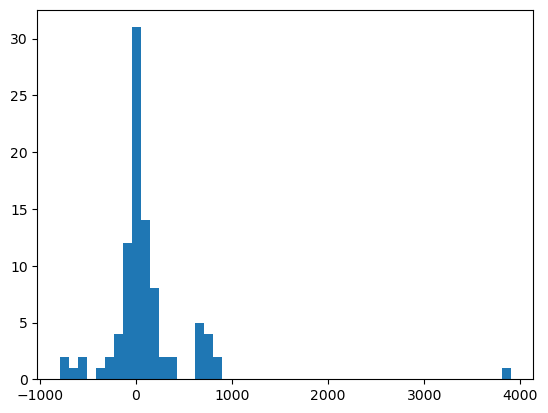

In [8]:
plt.hist(df['length_diff'], bins=50)
plt.show()

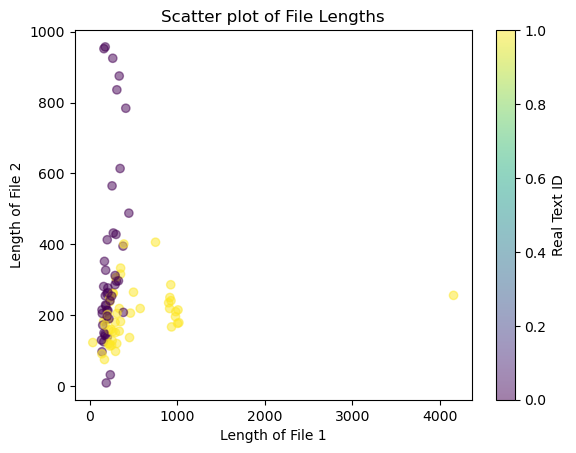

In [9]:
plt.scatter(x=df['length_1'], y=df['length_2'], c=df['real_text_id'], alpha=0.5)
plt.xlabel('Length of File 1')
plt.ylabel('Length of File 2')
plt.title('Scatter plot of File Lengths')
plt.colorbar(label='Real Text ID')
plt.show()

In [10]:
df[df['length_1'] > 2000]

,file_1,file_2,real_text_id,length_1,length_2,length_diff,special_char_ratio_1,special_char_ratio_2,special_char_ratio_diff
81,A key element for fully understanding galactic...,A key element for fully understanding how gala...,1,4158,256,3902,0.17911,0.178058,0.001052


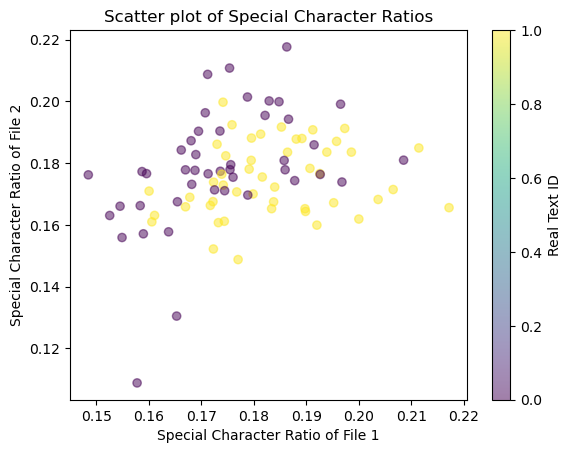

In [11]:
plt.scatter(df['special_char_ratio_1'], df['special_char_ratio_2'], c=df['real_text_id'], alpha=0.5)
plt.xlabel('Special Character Ratio of File 1')
plt.ylabel('Special Character Ratio of File 2')
plt.title('Scatter plot of Special Character Ratios')
plt.colorbar(label='Real Text ID')
plt.show()

In [12]:
df.describe()

,real_text_id,length_1,length_2,length_diff,special_char_ratio_1,special_char_ratio_2,special_char_ratio_diff
count,93.000000,93.000000,93.000000,93.000000,93.000000,93.000000,93.000000
mean,0.516129,383.247312,269.365591,113.881720,0.178595,0.176534,0.002061
std,0.502448,467.180294,193.964463,507.673463,0.013814,0.015799,0.017940
min,0.000000,34.000000,9.000000,-791.000000,0.148475,0.108772,-0.037563
25%,0.000000,191.000000,159.000000,-41.000000,0.169464,0.167464,-0.008867
50%,1.000000,256.000000,215.000000,19.000000,0.176042,0.176551,0.000603
75%,1.000000,351.000000,286.000000,169.000000,0.187784,0.186111,0.012394
max,1.000000,4158.000000,957.000000,3902.000000,0.217179,0.217657,0.051616


### Preprocessing

In [13]:
from scipy.sparse import hstack
    
num_features = df[['length_1', 'length_2', 'length_diff', 'special_char_ratio_1', 'special_char_ratio_2', 'special_char_ratio_diff']].values
text_features = df[['file_1', 'file_2']]
y = df['real_text_id']

In [14]:
from sklearn.model_selection import train_test_split

X_train_num, X_test_num, X_train_text, X_test_text, y_train_num, y_test_num = train_test_split(num_features, text_features, y, test_size=0.2, random_state=42)


In [15]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

# fitting on train data only
scaler.fit(X_train_num)

# transform both train and test data
X_train_num = scaler.transform(X_train_num)
X_test_num = scaler.transform(X_test_num)

In [35]:
from sklearn.feature_extraction.text import TfidfVectorizer

all_train = pd.concat([X_train_text['file_1'], X_train_text['file_2']], ignore_index=True)

vectorizer = TfidfVectorizer(stop_words='english', max_features=500)

# fit on training data only
vectorizer.fit(all_train)


,input,'content'
,encoding,'utf-8'
,decode_error,'strict'
,strip_accents,None
,lowercase,True
,preprocessor,None
,tokenizer,None
,analyzer,'word'
,stop_words,'english'
,token_pattern,'(?u)\\b\\w\\w+\\b'
,ngram_range,"(1, ...)"


In [36]:
from scipy.sparse import hstack

train_vector_1 = vectorizer.transform(X_train_text['file_1'])
train_vector_2 = vectorizer.transform(X_train_text['file_2'])
X_train_text_sparse = hstack([train_vector_1, train_vector_2])

In [37]:
test_vector_1 = vectorizer.transform(X_test_text['file_1'])
test_vector_2 = vectorizer.transform(X_test_text['file_2'])
X_test_text_sparse = hstack([test_vector_1, test_vector_2])

In [38]:
X_train_final = hstack([X_train_num, X_train_text_sparse])
X_test_final = hstack([X_test_num, X_test_text_sparse])

### Pairwise Classification modeling

#### Logistic Regression

In [49]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(C=1)
log_reg.fit(X_train_final, y_train_num)

y_pred_log_reg = log_reg.predict(X_test_final)
y_proba_log_reg = log_reg.predict_proba(X_test_final)[:, 1]

Logistic Regression Accuracy: 0.7894736842105263

Logistic Regression ROC AUC: 0.9204545454545454

Logistic Regression Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.91      0.83        11
           1       0.83      0.62      0.71         8

    accuracy                           0.79        19
   macro avg       0.80      0.77      0.77        19
weighted avg       0.80      0.79      0.78        19



Cross-validation Accuracy: 0.82 ± 0.07


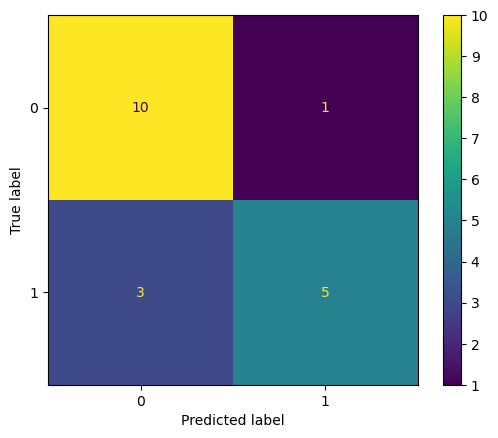

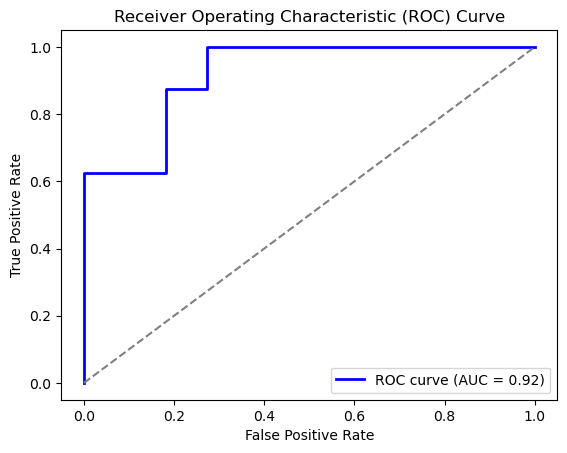

In [50]:
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, ConfusionMatrixDisplay, roc_curve, auc
from sklearn.model_selection import cross_val_score

print("Logistic Regression Accuracy:", accuracy_score(y_test_num, y_pred_log_reg))
print("\nLogistic Regression ROC AUC:", roc_auc_score(y_test_num, y_proba_log_reg))
print("\nLogistic Regression Classification Report:\n", classification_report(y_test_num, y_pred_log_reg))

cv_scores = cross_val_score(log_reg, X_train_final, y_train_num, cv=5, scoring='accuracy')    
print(f"\n\nCross-validation Accuracy: {cv_scores.mean():.2f} ± {cv_scores.std():.2f}")

ConfusionMatrixDisplay.from_estimator(log_reg, X_test_final, y_test_num)

# plot roc curve
fpr, tpr, thresholds = roc_curve(y_test_num, y_proba_log_reg)
roc_score = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_score:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

#### Random Forest

In [51]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

rf_clf = RandomForestClassifier()
param_grid = {
    'n_estimators': [200, 500],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2']
}

grid = GridSearchCV(rf_clf, param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
grid.fit(X_train_final, y_train_num)

print("Best params:", grid.best_params_)
print("Best CV ROC AUC:", grid.best_score_)

rf_clf = grid.best_estimator_

y_pred_rf = rf_clf.predict(X_test_final)
y_proba_rf = rf_clf.predict_proba(X_test_final)[:, 1]

Best params: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 500}
Best CV ROC AUC: 0.9130952380952382


Random Forest Accuracy: 0.6842105263157895

Random Forest ROC AUC: 0.8295454545454546

Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.91      0.77        11
           1       0.75      0.38      0.50         8

    accuracy                           0.68        19
   macro avg       0.71      0.64      0.63        19
weighted avg       0.70      0.68      0.66        19



Cross-validation Accuracy: 0.85 ± 0.03


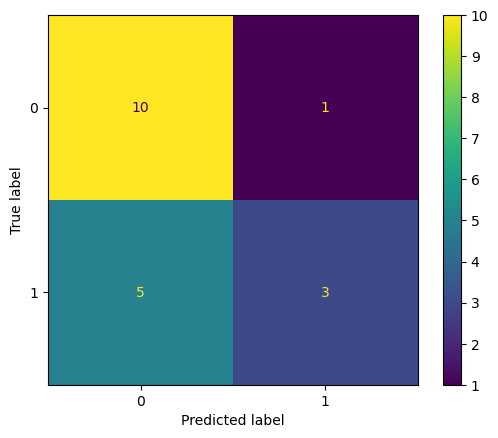

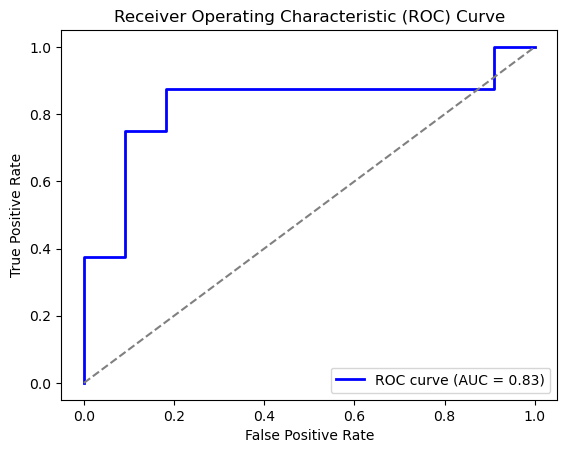

In [52]:
print("Random Forest Accuracy:", accuracy_score(y_test_num, y_pred_rf))
print("\nRandom Forest ROC AUC:", roc_auc_score(y_test_num, y_proba_rf))
print("\nRandom Forest Classification Report:\n", classification_report(y_test_num, y_pred_rf))

cv_scores = cross_val_score(rf_clf, X_train_final, y_train_num, cv=5, scoring='accuracy')    
print(f"\n\nCross-validation Accuracy: {cv_scores.mean():.2f} ± {cv_scores.std():.2f}")

ConfusionMatrixDisplay.from_estimator(rf_clf, X_test_final, y_test_num)

# plot roc curve
fpr, tpr, thresholds = roc_curve(y_test_num, y_proba_rf)
roc_score = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_score:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

### Ridge Classifier

In [32]:
from sklearn.linear_model import RidgeClassifier

ridge_clf = RidgeClassifier()
ridge_clf.fit(X_train_final, y_train_num)

y_pred_ridge = ridge_clf.predict(X_test_final)
# y_proba_ridge = ridge_clf.predict_proba(X_test_final)[:, 1]

Ridge Classifier Accuracy: 0.6842105263157895

Ridge Classifier Classification Report:
               precision    recall  f1-score   support

           0       0.69      0.82      0.75        11
           1       0.67      0.50      0.57         8

    accuracy                           0.68        19
   macro avg       0.68      0.66      0.66        19
weighted avg       0.68      0.68      0.67        19



Cross-validation Accuracy: 0.80 ± 0.09


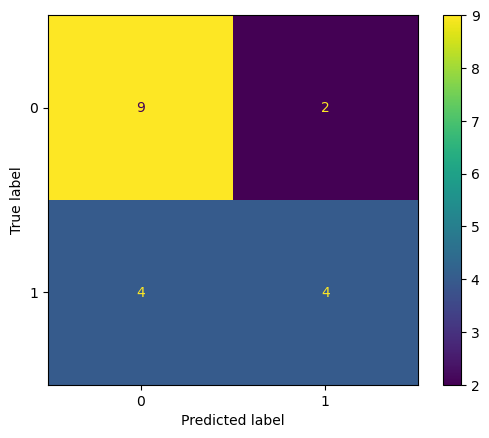

In [34]:
print("Ridge Classifier Accuracy:", accuracy_score(y_test_num, y_pred_ridge))
# print("\nRidge Classifier ROC AUC:", roc_auc_score(y_test_num, y_proba_ridge))
print("\nRidge Classifier Classification Report:\n", classification_report(y_test_num, y_pred_ridge))

cv_scores = cross_val_score(ridge_clf, X_train_final, y_train_num, cv=5, scoring='accuracy')    
print(f"\n\nCross-validation Accuracy: {cv_scores.mean():.2f} ± {cv_scores.std():.2f}")

ConfusionMatrixDisplay.from_estimator(ridge_clf, X_test_final, y_test_num)

# plot roc curve
# fpr, tpr, thresholds = roc_curve(y_test_num, y_proba_ridge)
roc_score = auc(fpr, tpr)

# plt.figure()
# plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_score:.2f})')
# plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Receiver Operating Characteristic (ROC) Curve')
# plt.legend(loc='lower right')
# plt.show()

### Predicting on test data

In [54]:
test = pd.read_csv('../data/test_processed.csv')
test.head()

,sample_id,file_1.txt_context,file_2.txt_context
0,article_0000,"""Music"" Music music music Music music Music mu...",Since its launch on Paranal observatory's Very...
1,article_0001,underground exploration on SN's birth has prov...,SN 1987A provides valuable insights as newer o...
2,article_0002,This research aimed to understand how star sha...,ChromeDriver music player\nThis study focused ...
3,article_0003,Using OmegaCAM's wide field capabilities spann...,"greek translation :\nvazhi (megaCAM), territor..."
4,article_0004,AssemblyCulture AssemblyCulture AssemblyCultur...,XClass is software tool that helps astronomers...


In [55]:
test = test.drop(columns=['sample_id'])

In [56]:
test.isna().sum()

file_1.txt_context    0
file_2.txt_context    1
dtype: int64

In [57]:
test.fillna("", inplace=True)

In [58]:
test = test.rename(columns={
    'file_1.txt_context': 'file_1',
    'file_2.txt_context': 'file_2'
})


In [59]:
test['length_1'] = test['file_1'].str.split().str.len()
test['length_2'] = test['file_2'].str.split().str.len()
test['length_diff'] = test['length_1'] - test['length_2']

test['special_char_ratio_1'] = test['file_1'].apply(lambda x: sum(1 for c in x if not c.isalnum()) / len(x) if len(x) > 0 else 0)
test['special_char_ratio_2'] = test['file_2'].apply(lambda x: sum(1 for c in x if not c.isalnum()) / len(x) if len(x) > 0 else 0)
test['special_char_ratio_diff'] = test['special_char_ratio_1'] - test['special_char_ratio_2']

In [60]:
num_features_test = test[['length_1', 'length_2', 'length_diff', 'special_char_ratio_1', 'special_char_ratio_2', 'special_char_ratio_diff']].values
text_features = test[['file_1', 'file_2']]

test_num = scaler.transform(num_features_test)

test_text_1 = vectorizer.transform(text_features['file_1'])
test_text_2 = vectorizer.transform(text_features['file_2'])

test_text = hstack([test_text_1, test_text_2])

test_final = hstack([test_num, test_text])


In [61]:
test_final.shape

(1068, 1006)

In [62]:
X_train_final.shape

(74, 1006)

In [63]:
test_preds_log_reg = log_reg.predict(test_final)
test_probas_log_reg = log_reg.predict_proba(test_final)[:, 1]

test_preds_rf = rf_clf.predict(test_final)
test_probas_rf = rf_clf.predict_proba(test_final)[:, 1]


In [64]:
test_preds_log_reg[:10]

array([1, 0, 0, 0, 1, 0, 1, 0, 1, 0])

In [65]:
test_preds_rf[:10]

array([1, 0, 0, 0, 0, 0, 1, 0, 1, 0])

In [66]:
log_reg_results = pd.DataFrame({'id': range(len(test)), 'real_text_id': test_preds_log_reg})
log_reg_results['real_text_id'] += 1
rf_results = pd.DataFrame({'id': range(len(test)), 'real_text_id': test_preds_rf})
rf_results['real_text_id'] += 1


In [67]:
log_reg_results['real_text_id'].value_counts()

real_text_id
1    669
2    399
Name: count, dtype: int64

In [68]:
rf_results['real_text_id'].value_counts()

real_text_id
1    677
2    391
Name: count, dtype: int64

In [69]:
log_reg_results.to_csv('../data/submissions/log_reg_pairwise_submission.csv', index=False)
rf_results.to_csv('../data/submissions/random_forest_pairwise_submission.csv', index=False)
